In [1]:
'''
更改输入数据的标签——增加“空气”/“牙体内部”类别。
由于模型默认是多分类，激活函数必须是softmax。
'''

'\n更改输入数据的标签——增加“空气”/“牙体内部”类别。\n由于模型默认是多分类，激活函数必须是softmax。\n'

In [2]:
'''
统一设置地址
'''

import os

# 获取当前工作目录
current_dir = os.getcwd()
print("当前工作目录：", current_dir)

# 修改当前工作目录，以后输出文件只需要写文件名
new_dir = "D:/李娅宁/肩台外侧点-0715/"
os.chdir(new_dir)
print("修改后的工作目录：", os.getcwd())


当前工作目录： C:\Users\HP
修改后的工作目录： D:\李娅宁\肩台外侧点-0715


In [3]:
'''
UNET
这一版能运行，但学习遇到瓶颈，最终效果不够好
接下来要通过更改网络结构来改进
我发现代码慢是慢在加载数据
'''

import numpy as np
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 读取点云数据和标签
def load_labeled_point_cloud(file_path):
    data = []
    labels = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) == 4:
                x, y, z, label = map(float, parts)
                data.append([x, y, z])
                labels.append(int(label))
    return np.array(data), np.array(labels)

# 创建带标签的体素网格
def create_labeled_voxel_grid(data, labels, grid_size):
    if data.size == 0 or labels.size == 0:
        print(f"Warning: Empty data or labels array. data.size={data.size}, labels.size={labels.size}")
        return None, None

    grid = np.zeros((grid_size, grid_size, grid_size))
    label_grid = np.zeros((grid_size, grid_size, grid_size), dtype=int)  # Initialize with 0 to indicate empty space

    min_coords = np.min(data, axis=0)
    max_coords = np.max(data, axis=0)
    voxel_dim = (max_coords - min_coords) / grid_size

    for i, point in enumerate(data):
        voxel = ((point - min_coords) / voxel_dim).astype(int)
        voxel = np.clip(voxel, 0, grid_size-1)  # Ensure indices are within bounds
        grid[voxel[0], voxel[1], voxel[2]] = 1
        label_grid[voxel[0], voxel[1], voxel[2]] = labels[i]  # Use original labels (1 and 2)

    return grid, label_grid

# 数据增强
def augment_voxel_grid(voxel_grid):
    """
    对体素网格进行随机旋转和翻转。
    """
    # 随机旋转
    angle = np.random.uniform(0, 360)
    voxel_grid = np.rot90(voxel_grid, k=int(angle // 90), axes=(0, 1))
    
    # 随机翻转
    if np.random.rand() > 0.5:
        voxel_grid = np.flip(voxel_grid, axis=0)
    if np.random.rand() > 0.5:
        voxel_grid = np.flip(voxel_grid, axis=1)
    if np.random.rand() > 0.5:
        voxel_grid = np.flip(voxel_grid, axis=2)
    
    return voxel_grid

# 从文件夹中读取数据并加工成体素网格
def load_data_from_directory(data_dir, grid_size=16):
    x_data = []
    y_data = []
    for file in os.listdir(data_dir):
        if file.endswith("_labeled.txt"):
            file_path = os.path.join(data_dir, file)
            data, labels = load_labeled_point_cloud(file_path)
            if data.size == 0 or labels.size == 0:
                print(f"Skipping empty file: {file_path}")
                continue
            voxel_grid, label_grid = create_labeled_voxel_grid(data, labels, grid_size)
            if voxel_grid is not None and label_grid is not None:
                # 关闭数据增强
                # voxel_grid = augment_voxel_grid(voxel_grid)
                x_data.append(voxel_grid)
                y_data.append(label_grid)
    x_data = np.expand_dims(np.array(x_data), axis=-1)
    y_data = np.expand_dims(np.array(y_data), axis=-1)
    return x_data, y_data



'''
加载数据很慢，调试网络时应当只重新定义、编译、训练模型而不重新加载数据
'''

# 加载数据
data_dir = '重新处理后的数据_手工筛选'
x_data, y_data = load_data_from_directory(data_dir, grid_size=16)

# 确保数据归一化
x_data = x_data / np.max(x_data)

# 确保标签是0, 1, 2
y_data = y_data.astype(np.int32)

# 划分数据集
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.2, random_state=42
)


In [4]:
# 绘制训练过程中的损失和精确度
def plot_training_history(history):
    """
    绘制训练过程中的损失和精确度。
    """
    # 绘制损失
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    # 绘制精确度
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [5]:
# 定义UNET模型
def unet_3d(input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Encoder
    conv1 = tf.keras.layers.Conv3D(64, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(inputs)
    conv1 = tf.keras.layers.Conv3D(64, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(conv1)
    pool1 = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2))(conv1)

    conv2 = tf.keras.layers.Conv3D(128, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(pool1)
    conv2 = tf.keras.layers.Conv3D(128, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(conv2)
    pool2 = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2))(conv2)

    conv3 = tf.keras.layers.Conv3D(256, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(pool2)
    conv3 = tf.keras.layers.Conv3D(256, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(conv3)
    pool3 = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2))(conv3)

    # Bottleneck
    conv4 = tf.keras.layers.Conv3D(512, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(pool3)
    conv4 = tf.keras.layers.Conv3D(512, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(conv4)

    # Decoder
    up5 = tf.keras.layers.Conv3DTranspose(256, 2, strides=(2, 2, 2), padding='same')(conv4)
    concat5 = tf.keras.layers.concatenate([up5, conv3], axis=-1)
    conv5 = tf.keras.layers.Conv3D(256, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(concat5)
    conv5 = tf.keras.layers.Conv3D(256, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(conv5)

    up6 = tf.keras.layers.Conv3DTranspose(128, 2, strides=(2, 2, 2), padding='same')(conv5)
    concat6 = tf.keras.layers.concatenate([up6, conv2], axis=-1)
    conv6 = tf.keras.layers.Conv3D(128, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(concat6)
    conv6 = tf.keras.layers.Conv3D(128, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(conv6)

    up7 = tf.keras.layers.Conv3DTranspose(64, 2, strides=(2, 2, 2), padding='same')(conv6)
    concat7 = tf.keras.layers.concatenate([up7, conv1], axis=-1)
    conv7 = tf.keras.layers.Conv3D(64, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(concat7)
    conv7 = tf.keras.layers.Conv3D(64, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(conv7)

    # 修改输出层，适应3个类别
    outputs = tf.keras.layers.Conv3D(3, 1, activation='softmax')(conv7)  # 3 channels for three-class classification

    model = tf.keras.models.Model(inputs=[inputs], outputs=[outputs])
    return model


In [19]:
'''
定义各种损失函数
'''

import tensorflow.keras.backend as K

# 交叉熵
def cross_entropy_loss(y_true, y_pred):
    return tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=True))

# Dice
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3, 4])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3, 4]) + tf.reduce_sum(y_pred, axis=[1, 2, 3, 4])
    dice = (2. * intersection + smooth) / (union + smooth)
    
    return tf.reduce_mean(1 - dice)

# Tversky
def tversky_loss(y_true, y_pred, alpha=0.7, beta=0.3, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3, 4])
    false_neg = tf.reduce_sum(y_true * (1 - y_pred), axis=[1, 2, 3, 4])
    false_pos = tf.reduce_sum((1 - y_true) * y_pred, axis=[1, 2, 3, 4])
    
    tversky = (intersection + smooth) / (intersection + alpha * false_neg + beta * false_pos + smooth)
    
    return tf.reduce_mean(1 - tversky)

# Focal
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        # 确保 y_true 和 y_pred 都是 float32 类型
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
        # 计算交叉熵
        cross_entropy = -y_true * tf.math.log(y_pred)
        # 计算 focal 权重
        focal_weight = alpha * tf.math.pow(1 - y_pred, gamma)
        # 计算 focal loss
        loss = focal_weight * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(loss, axis=-1))
    return focal_loss_fixed


# Hausdorff距离
from scipy.spatial.distance import directed_hausdorff

def hausdorff_distance(y_true, y_pred):
    """
    计算 Hausdorff 距离
    :param y_true: 真实标签图像 (batch_size, height, width, depth, channels)
    :param y_pred: 预测标签图像 (batch_size, height, width, depth, channels)
    :return: Hausdorff 距离
    """
    # 将 y_true 和 y_pred 转换为二值化图像
    y_true_bin = tf.cast(y_true > 0.5, tf.float32)
    y_pred_bin = tf.cast(y_pred > 0.5, tf.float32)
    
    def get_coordinates(binary_mask):
        # 获取二值化图像的坐标
        coords = tf.where(binary_mask > 0.5)
        return coords
    
    def hausdorff_distance_batch(y_true, y_pred):
        # 计算每个批次的 Hausdorff 距离
        batch_size = tf.shape(y_true)[0]
        dist_list = []

        for b in range(batch_size):
            y_true_coords = get_coordinates(y_true[b]).numpy()
            y_pred_coords = get_coordinates(y_pred[b]).numpy()
            
            if len(y_true_coords) == 0 or len(y_pred_coords) == 0:
                # 如果某一批次中有空图像，返回最大值作为 Hausdorff 距离
                dist_list.append(0.0)
                continue
            
            # 计算 Hausdorff 距离
            dist_1 = directed_hausdorff(y_true_coords, y_pred_coords)[0]
            dist_2 = directed_hausdorff(y_pred_coords, y_true_coords)[0]
            
            dist_list.append(max(dist_1, dist_2))
        
        return tf.reduce_mean(tf.convert_to_tensor(dist_list, dtype=tf.float32))
    
    return tf.py_function(hausdorff_distance_batch, [y_true_bin, y_pred_bin], tf.float32)


# Boundary
def boundary_loss(y_true, y_pred, weight=1.0):
    """
    计算边界损失
    :param y_true: 真实标签图像 (batch_size, height, width, depth, channels)
    :param y_pred: 预测标签图像 (batch_size, height, width, depth, channels)
    :param weight: 边界损失的权重
    :return: 边界损失
    """
    y_true = tf.cast(y_true > 0.5, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    
    def compute_boundary(x):
        # 边界的简单估计（基于图像梯度）
        kernel = tf.constant([[1, -1], [-1, 1]], dtype=tf.float32)
        kernel = tf.reshape(kernel, [2, 2, 1, 1])
        boundary = tf.nn.conv2d(x, kernel, strides=[1, 1, 1, 1], padding='SAME')
        return tf.reduce_sum(tf.abs(boundary))
    
    boundary_true = compute_boundary(y_true)
    boundary_pred = compute_boundary(y_pred)
    
    boundary_loss = tf.reduce_mean(tf.abs(boundary_true - boundary_pred))
    return weight * boundary_loss


# Boundary-Awar
def boundary_aware_loss(y_true, y_pred, alpha=0.5):
    """
    计算边界感知损失
    :param y_true: 真实标签图像 (batch_size, height, width, depth, channels)
    :param y_pred: 预测标签图像 (batch_size, height, width, depth, channels)
    :param alpha: 边界感知损失的权重
    :return: 边界感知损失
    """
    # 二值化预测结果
    y_true = tf.cast(y_true > 0.5, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    
    # 计算边界
    def compute_boundary(x):
        # 边界的简单估计（基于图像梯度）
        kernel = tf.constant([[1, -1], [-1, 1]], dtype=tf.float32)
        boundary = tf.nn.conv2d(x, kernel[tf.newaxis, tf.newaxis, :, :], strides=[1, 1, 1, 1], padding='SAME')
        return tf.reduce_sum(tf.abs(boundary))
    
    boundary_true = compute_boundary(y_true)
    boundary_pred = compute_boundary(y_pred)
    
    # 分类损失
    ce_loss = tf.keras.losses.SparseCategoricalCrossentropy()(y_true, y_pred)
    
    # 边界感知损失
    boundary_loss = tf.reduce_mean(tf.abs(boundary_true - boundary_pred))
    
    return ce_loss + alpha * boundary_loss


# 组合损失函数
@tf.function
def combined_loss(y_true, y_pred):
    ce_loss = cross_entropy_loss(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    tversky = tversky_loss(y_true, y_pred)
    focal = focal_loss(gamma=2.0, alpha=0.25)(y_true, y_pred)
    
    return ce_loss + dice + tversky

In [ ]:
# 定义模型
input_shape = (16, 16, 16, 1)
model = unet_3d(input_shape)


# 定义学习率调度函数
def scheduler(epoch, lr):
    if epoch < 5:
        return float(lr)
    else:
        return float(lr * tf.math.exp(-0.1).numpy())

# 定义学习率调度回调和早停回调
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


# 编译模型
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00002), 
              loss=combined_loss,
              metrics=['accuracy'])

# 训练模型
history = model.fit(
    x_train, y_train, 
    validation_split=0.1,
    epochs=20, 
    batch_size=10,
    callbacks=[lr_scheduler, early_stopping]
)

# 评估模型
test_loss, test_accuracy = model.evaluate(x_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


# 显示炼丹过程
plot_training_history(history)

# 保存模型
model_save_path = 'July30语义分割模型/UNET_softmax_无数据增强.h5'
model.save(model_save_path)
print(f"Model saved to {model_save_path}")


Epoch 1/20
 6/69 [=>............................] - ETA: 10:51 - loss: 2.4935 - accuracy: 0.3843

In [6]:
# 加载模型
model_load_path = 'July30语义分割模型/UNET_softmax.h5'
model = tf.keras.models.load_model(model_load_path)

In [8]:
# 开启交互旋转
%matplotlib notebook


In [9]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import combinations

def load_obj_file(file_path):
    vertices = []
    faces = []
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('v '):
                vertices.append(list(map(float, line.strip().split()[1:])))
            elif line.startswith('f '):
                faces.append([int(idx.split('/')[0]) - 1 for idx in line.strip().split()[1:]])
    return np.array(vertices), np.array(faces)

def center_vertices(vertices):
    centroid = np.mean(vertices, axis=0)
    return vertices - centroid


In [10]:
def rotate_points(points, angles):
    x_angle, y_angle, z_angle = angles
    Rx = np.array([
        [1, 0, 0],
        [0, np.cos(x_angle), -np.sin(x_angle)],
        [0, np.sin(x_angle), np.cos(x_angle)]
    ])
    Ry = np.array([
        [np.cos(y_angle), 0, np.sin(y_angle)],
        [0, 1, 0],
        [-np.sin(y_angle), 0, np.cos(y_angle)]
    ])
    Rz = np.array([
        [np.cos(z_angle), -np.sin(z_angle), 0],
        [np.sin(z_angle), np.cos(z_angle), 0],
        [0, 0, 1]
    ])
    R = Rz @ Ry @ Rx
    return points @ R.T


In [11]:
def create_voxel_grid(points, grid_size):
    min_coords = np.min(points, axis=0)
    max_coords = np.max(points, axis=0)
    voxel_dim = (max_coords - min_coords) / grid_size
    
    voxel_grid = np.zeros((grid_size, grid_size, grid_size), dtype=np.int32)
    for point in points:
        voxel = ((point - min_coords) / voxel_dim).astype(int)
        voxel = np.clip(voxel, 0, grid_size-1)
        voxel_grid[voxel[0], voxel[1], voxel[2]] += 1
    
    return voxel_grid, min_coords, voxel_dim


In [12]:
def get_labels_from_model(model, voxel_grid):
    voxel_grid = np.expand_dims(voxel_grid, axis=0)  # Add batch dimension
    voxel_grid = np.expand_dims(voxel_grid, axis=-1)  # Add channel dimension
    predictions = model.predict(voxel_grid)
    
    labels = np.argmax(predictions, axis=-1)  # Get the class with the highest probability
    labels = labels.reshape(voxel_grid.shape[1], voxel_grid.shape[2], voxel_grid.shape[3])
    
    return labels


In [13]:
def apply_labels_to_point_cloud(data, predicted_labels, min_coords, voxel_dim, grid_size):
    labels = np.zeros(len(data))
    for i, point in enumerate(data):
        voxel = ((point - min_coords) / voxel_dim).astype(int)
        voxel = np.clip(voxel, 0, grid_size-1)
        labels[i] = predicted_labels[voxel[0], voxel[1], voxel[2]]
    return labels


In [14]:
def find_boundary_edges(vertices, faces, labels):
    edges = defaultdict(list)
    for face in faces:
        for (v1, v2) in combinations(face, 2):
            if labels[v1] != labels[v2]:
                edges[tuple(sorted([v1, v2]))].append(face)
    
    # Create an adjacency list for edges
    adjacency_list = defaultdict(list)
    for (v1, v2), faces in edges.items():
        adjacency_list[v1].append(v2)
        adjacency_list[v2].append(v1)
    
    # Find all connected components of edges
    visited = set()
    boundary_lines = []
    for vertex in adjacency_list:
        if vertex not in visited:
            stack = [vertex]
            boundary_line = []
            while stack:
                current = stack.pop()
                if current not in visited:
                    visited.add(current)
                    boundary_line.append(current)
                    for neighbor in adjacency_list[current]:
                        if neighbor not in visited:
                            stack.append(neighbor)
            boundary_lines.append(boundary_line)
    
    # Calculate the length of each boundary line and sort by length
    boundary_lines = sorted(boundary_lines, key=lambda line: sum(np.linalg.norm(vertices[line[i]] - vertices[line[i + 1]]) for i in range(len(line) - 1)), reverse=True)
    return boundary_lines


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


<IPython.core.display.Javascript object>


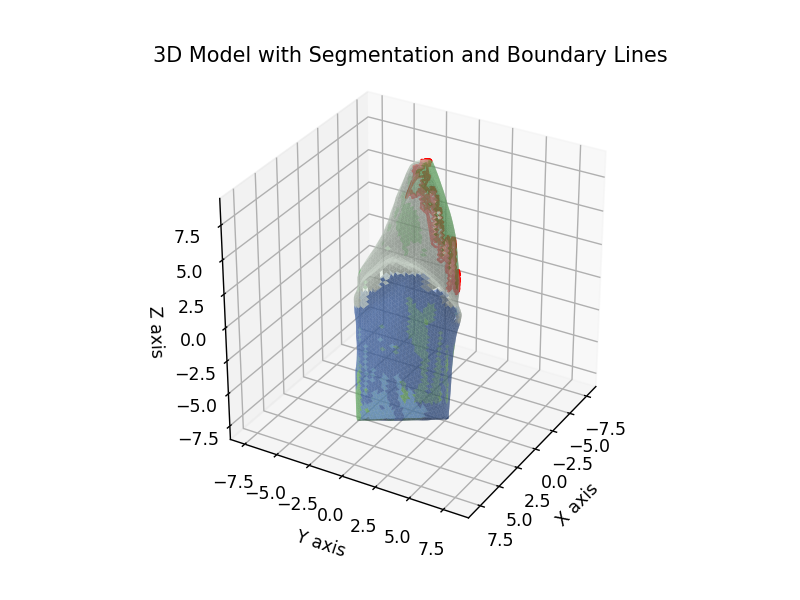

In [41]:
'''
三分类可视化
'''

def plot_surface_with_marks(vertices, faces, labels, part1, part2, view_angles=(30, 30), angles=(0, 0, 0)):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    vertices = np.array(vertices)
    faces = np.array(faces)

    # Apply rotation
    vertices = rotate_points(vertices, angles)
    
    x, y, z = vertices.T

    try:
        # 标记分割的点云部分
        part0_faces = [face for face in faces if sum(labels[vertex] == 0 for vertex in face) > 1]
        part1_faces = [face for face in faces if sum(labels[vertex] == 1 for vertex in face) > 1]
        part2_faces = [face for face in faces if sum(labels[vertex] == 2 for vertex in face) > 1]
        
        part0_faces = np.array(part0_faces)
        part1_faces = np.array(part1_faces)
        part2_faces = np.array(part2_faces)
        
        if len(part0_faces) > 0:
            ax.plot_trisurf(vertices[:, 0], vertices[:, 1], vertices[:, 2], triangles=part0_faces, color='lightgreen', alpha=0.6)
        if len(part1_faces) > 0:
            ax.plot_trisurf(vertices[:, 0], vertices[:, 1], vertices[:, 2], triangles=part1_faces, color='cornflowerblue', alpha=0.6)
        if len(part2_faces) > 0:
            ax.plot_trisurf(vertices[:, 0], vertices[:, 1], vertices[:, 2], triangles=part2_faces, color='honeydew', alpha=0.6)

        # 找到边界线并绘制最长的边界线
        boundary_lines = find_boundary_edges(vertices, faces, labels)
        if boundary_lines:
            longest_boundary_line = boundary_lines[0]
            ax.plot(vertices[longest_boundary_line, 0], vertices[longest_boundary_line, 1], vertices[longest_boundary_line, 2], color='red')
            
    except ValueError as e:
        print(f"ValueError: {e}")
        return

    # 设置标签和标题
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_title('3D Model with Segmentation and Boundary Lines')

    # 确保坐标轴刻度一致
    max_range = np.array([max(x)-min(x), max(y)-min(y), max(z)-min(z)]).max()
    mid_x = (max(x) + min(x)) * 0.5
    mid_y = (max(y) + min(y)) * 0.5
    mid_z = (max(z) + min(z)) * 0.5
    ax.set_xlim(mid_x - max_range/2, mid_x + max_range/2)
    ax.set_ylim(mid_y - max_range/2, mid_y + max_range/2)
    ax.set_zlim(mid_z - max_range/2, mid_z + max_range/2)

    # 设置视角
    elev, azim = view_angles
    ax.view_init(elev=elev, azim=azim)  # Adjust these values as needed

    # 确保坐标轴比例相等
    ax.set_box_aspect([1,1,1])  # Aspect ratio is 1:1:1

    # 启用交互式旋转
    plt.show()

# 加载点云数据
obj_file_path = r'D:/李娅宁/肩台外侧点-0715/已完成预处理的原始数据/15/15_1.obj'
vertices, faces = load_obj_file(obj_file_path)
centered_vertices = center_vertices(vertices)

# 将点云转换为体素网格
grid_size = 16  # Ensure grid size matches model requirements
voxel_grid, min_coords, voxel_dim = create_voxel_grid(np.array(centered_vertices), grid_size)

# 使用训练好的模型进行预测
predicted_labels = get_labels_from_model(model, voxel_grid)

# 获取原始点云的预测标签
predicted_point_labels = apply_labels_to_point_cloud(np.array(centered_vertices), predicted_labels, min_coords, voxel_dim, grid_size)

# 定义分割的部分（需要根据实际情况定义）
part1 = {i for i, label in enumerate(predicted_point_labels) if label == 0}
part2 = {i for i, label in enumerate(predicted_point_labels) if label == 1}

# 画图
plot_surface_with_marks(centered_vertices, faces, predicted_point_labels, part1, part2, view_angles=(30, 30), angles=(np.radians(90), np.radians(-30), np.radians(30)))


In [ ]:
'''
重写牙根牙冠分界线：
1.给点云赋予分类标签；
2.给点云赋予拓扑图；
3.找到标签为1和2的两个最大连通子图，以这两个子图的分界线作为牙根牙冠分界线。
'''

In [15]:
'''
新增的拓扑图函数
'''

import numpy as np
import networkx as nx
from sklearn.neighbors import NearestNeighbors

def build_topology_graph(vertices, k=10):
    # 计算k近邻图
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(vertices)
    distances, indices = nbrs.kneighbors(vertices)
    
    G = nx.Graph()
    for i, neighbors in enumerate(indices):
        for j in neighbors:
            if i != j:
                G.add_edge(i, j)
                
    return G


In [16]:
def largest_connected_component(G, nodes):
    subgraph = G.subgraph(nodes)
    largest_cc = max(nx.connected_components(subgraph), key=len)
    return subgraph.subgraph(largest_cc)

def get_max_connected_subgraphs(G, labels, target_labels):
    subgraphs = {}
    for label in target_labels:
        nodes = [i for i, l in enumerate(labels) if l == label]
        if nodes:
            largest_cc = largest_connected_component(G, nodes)
            subgraphs[label] = largest_cc
    return subgraphs


In [17]:
'''
找边界线的函数改了
'''

def find_boundary_edges(G, subgraph1, subgraph2):
    boundary_edges = []
    for edge in G.edges():
        if (edge[0] in subgraph1 and edge[1] in subgraph2) or (edge[0] in subgraph2 and edge[1] in subgraph1):
            boundary_edges.append(edge)
    return boundary_edges

def plot_surface_with_boundary_lines(vertices, faces, labels, boundary_edges, view_angles=(30, 30), angles=(0, 0, 0)):
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d.art3d import Line3DCollection

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    vertices = np.array(vertices)
    faces = np.array(faces)
    
    # Apply rotation
    vertices = rotate_points(vertices, angles)
    
    x, y, z = vertices.T
    
    # 绘制不同标签区域的点云
    colors = ['lightgreen', 'cornflowerblue', 'honeydew']
    for i in range(3):
        part_faces = [face for face in faces if sum(labels[vertex] == i for vertex in face) > 1]
        if len(part_faces) > 0:
            ax.plot_trisurf(vertices[:, 0], vertices[:, 1], vertices[:, 2], triangles=part_faces, color=colors[i], alpha=0.6)
    
    # 绘制边界线
    for edge in boundary_edges:
        p1, p2 = vertices[list(edge)]
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], color='red', lw=1)
    
    # 设置标签和标题
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_title('3D Model with Boundary Lines')

    # 确保坐标轴刻度一致
    max_range = np.array([max(x)-min(x), max(y)-min(y), max(z)-min(z)]).max()
    mid_x = (max(x) + min(x)) * 0.5
    mid_y = (max(y) + min(y)) * 0.5
    mid_z = (max(z) + min(z)) * 0.5
    ax.set_xlim(mid_x - max_range/2, mid_x + max_range/2)
    ax.set_ylim(mid_y - max_range/2, mid_y + max_range/2)
    ax.set_zlim(mid_z - max_range/2, mid_z + max_range/2)

    # 设置视角
    elev, azim = view_angles
    ax.view_init(elev=elev, azim=azim)  # Adjust these values as needed

    # 确保坐标轴比例相等
    ax.set_box_aspect([1,1,1])  # Aspect ratio is 1:1:1

    # 启用交互式旋转
    plt.show()


1/1 [==============================] - 4s 4s/step


<IPython.core.display.Javascript object>


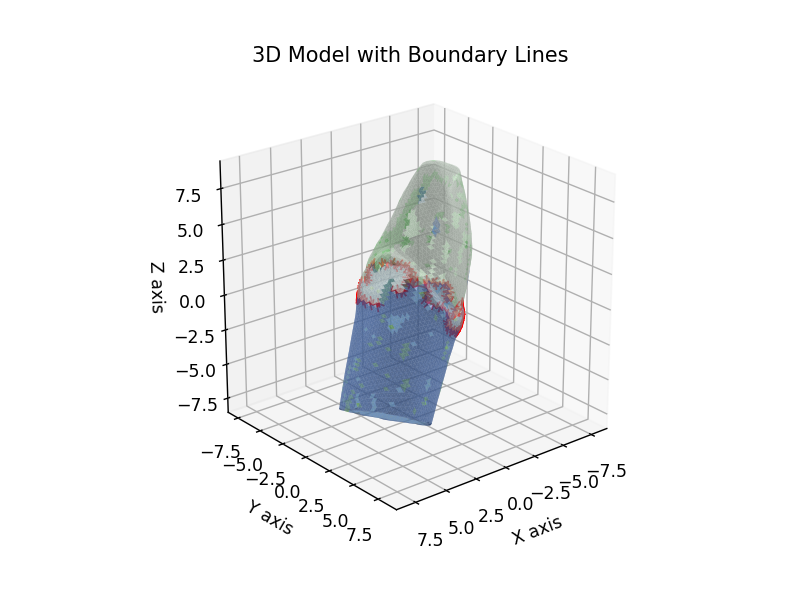

In [18]:
# 加载点云数据
obj_file_path = r'D:/李娅宁/肩台外侧点-0715/已完成预处理的原始数据/15/15_1.obj'
vertices, faces = load_obj_file(obj_file_path)
centered_vertices = center_vertices(vertices)

# 将点云转换为体素网格
grid_size = 16  # Ensure grid size matches model requirements
voxel_grid, min_coords, voxel_dim = create_voxel_grid(np.array(centered_vertices), grid_size)

# 使用训练好的模型进行预测
predicted_labels = get_labels_from_model(model, voxel_grid)

# 获取原始点云的预测标签
predicted_point_labels = apply_labels_to_point_cloud(np.array(centered_vertices), predicted_labels, min_coords, voxel_dim, grid_size)

# 构建拓扑图
G = build_topology_graph(centered_vertices)

# 找到最大连通子图
target_labels = [1, 2]
subgraphs = get_max_connected_subgraphs(G, predicted_point_labels, target_labels)

# 找到边界线
boundary_edges = find_boundary_edges(G, subgraphs[1], subgraphs[2])

# 绘制点云及边界线
plot_surface_with_boundary_lines(centered_vertices, faces, predicted_point_labels, boundary_edges, view_angles=(30, 30), angles=(np.radians(90), np.radians(-30), np.radians(30)))


In [75]:
'''
接下来有两个任务：
1.分界线平滑处理；
2.纠正标签；
必须使用能够适应多分类的技术策略，而且要尽可能鲁棒。
'''

'\n接下来有两个任务：\n1.分界线平滑处理；\n2.纠正标签；\n必须使用能够适应多分类的技术策略，而且要尽可能鲁棒。\n'